In [168]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from scipy.signal import find_peaks
import sys
import os
import pandas as pd

In [169]:
#Function definitions
#Import theoretical spectra. Names follow the convention "molecule form wide functional"
#molecule='68'
#form='closed'
#functional=['pbe0','pbe0-d3']
def read_theo(mol,f,fun):
    script_dir = os.getcwd()
    filename=mol+' '+f+" wide "+fun+'.txt'
#Relative path to directory with theoretical spectra e.g. 0068_closed
    rel_path='00'+mol+'_'+f+'/'
    path=os.path.join(script_dir,rel_path)
    theo_spec=genfromtxt(path+filename, delimiter='     ',dtype=float)
    return theo_spec
#Theoretical peak detection
def theo_peaks(SF,wavenumbers_theo,heights_theo):
    #D=8
    D=8
    H=0.02
    peaks_theo, _ = find_peaks(heights_theo,height=H,threshold=T,distance=D)
    return peaks_theo
#error calculation
#Calculate errors
def calculate_MAE():
    print("Error calculation:")
    #ADJUSTABLE PARAMETERS
    #tolerance for wavenumbers (when range jump is required)
    tol=100.0
    #tolerance for height ratio (when the exp and theoretical heights are so off that the band assignement must be wrong)
    htol=2.0
    error=[]
    #Sort from highest exp
    s=np.array(h_exp)
    sort_exp=s.argsort()[::-1][:len(h_exp)]
#    print("SORTED")
 #   print(sort_exp)
 #   for i in range(len(sort_exp)):
  #      print(y[sort_exp[i]],h_exp[sort_exp[i]])
        #Sort from highest theo
    s=np.array(h_theo)
    sort_theo=s.argsort()[::-1][:len(h_theo)]
#    print("SORTED")
 #   print(sort_theo)
 #   for i in range(len(sort_theo)):
  #      print(y_theo[sort_theo[i]],h_theo[sort_theo[i]])
    
    #Start from the highest experimental peak
    max_exp = max(range(len(h_exp)), key=h_exp.__getitem__)
    print("Maximum exp. peak at ",y[max_exp]," height: ",h_exp[max_exp])
    #Start close with theoretical peaks
#    max_position=y[max_exp]
#    lst=[abs(i-max_position) for i in y_theo]
#    max_theo = np.argmin(lst)
#    print("Starting peak at ",y_theo[max_theo]," height: ",h_theo[max_theo])
    
    #Starting index for theoretical spectrum
 #   j=max_theo-5
    j=0
 #   j=sort_theo[k]
    assigned=[]
    assigned_theo_number=[]
    assigned_exp_number=[]
    to_assign=20
    index=0
# Starting index for experimental spectrum. We go right first.
    for k in range(0,to_assign):
        matching_peak=y_theo[0]
        i=sort_exp[k]
        for l in range(len(sort_theo)):
            j=sort_theo[l]
            if abs(y[i]-y_theo[j])<abs(y[i]-matching_peak) and h_exp[i]/h_theo[j]<htol and h_theo[j]/h_exp[i]<htol and j not in assigned_theo_number:
                matching_peak=y_theo[j]
                index=j
        if abs(y[i]-matching_peak)<tol:
            error.append(y[i]-matching_peak)
            assigned.append([y[i],matching_peak])
            assigned_theo_number.append(index)
            assigned_exp_number.append(i) 
# Trying to match missing peaks
    for k in range(0,to_assign):
        matching_peak=0.0
        i=sort_exp[k]
        if i not in assigned_exp_number:
            print('Warning: accepted tolerance not achieved for peak {}'.format(y[i]))
            for l in range(len(sort_theo)):
                j=sort_theo[l]
                if abs(y[i]-y_theo[j])<abs(y[i]-matching_peak) and h_exp[i]/h_theo[j]<htol and h_theo[j]/h_exp[i]<htol:
                    matching_peak=y_theo[j]
                    index=j
                    
            print("Consider these matches manually:")
            print("For experimental peak {} cm-1, height {}, best theoretical match is {} cm-1, height {}".format(y[i], h_exp[i],y_theo[index],h_theo[index]))
       #     error.append(y[i]-matching_peak)
       #     assigned.append([y[i],matching_peak])
        #    assigned_theo_number.append(index)
        #    assigned_exp_number.append(i) 
                    
#        else: 
 #           print('Match for {}  not found, skipping the experimental peak'.format(y[i]))
    print("\n {} peaks were assigned. Scaling factor of {} was used for the theoretical spectrum.\n".format(len(error),SF))
  #  t=[range(len(error)),assigned[0], assigned [1],[i/SF for i in assigned[1]], [h_exp[i] for i in assigned_exp_number],[h_theo[i] for i in assigned_theo_number]]
  #  df=pd.DataFrame(assigned,[i/SF for i in assigned[1]], [h_exp[i] for i in assigned_exp_number],[h_theo[i] for i in assigned_theo_number],["Exp. waveno. "," Scaled theor. waveno.","  Theor. unscaled waveno ","   Exp. peak height "," Theor. peak height"])
    df=pd.DataFrame(assigned,columns=["Exp. waveno.","Scaled theo. waveno."])
 #   df["Theor. unscaled waveno"]=[i/SF for i in assigned[1]]
    df["Exp. peak height"]=[h_exp[i] for i in assigned_exp_number]
    df["Theo. peak height"]=[h_theo[i] for i in assigned_theo_number]
    df['Deviations']=df["Exp. waveno."]-df["Scaled theo. waveno."]
    display(df)
 #   table=tabulate(transposedT,headers= ["Exp. waveno. "," Scaled theor. waveno.","  Theor. unscaled waveno ","   Exp. peak height "," Theor. peak height"],tablefmt='simple')
 #   print(table)
   # print("   |Exp. waveno. | Scaled theor. waveno. |  Theor. unscaled waveno | cm-1|   Exp. peak height (normalized) | Theor. peak height (normalized)")
 #   k=0
#    for i in assigned:
 #       w=assigned_exp_number[k]
 #       v=assigned_theo_number[k]
 #       print(k," | ",i[0]," | ",i[1],"         | ", i[1]/SF," |    |",h_exp[w],"         | ",h_theo[v])
  #      k=k+1

    print("\n Mean absolute error: \n")
    MAE=   sum(abs(i) for i in error)/len(error)
    print("MAE = {} cm-1".format(round(MAE,2)))
    return MAE,len(error)


In [170]:
script_dir = os.getcwd()
np.set_printoptions(precision=6,threshold=sys.maxsize)

In [171]:
#set parameters
H=0.04
#H=0.05
T=0.0
D=8
#experimental resolution
res=8.0

In [172]:
#Input data parameters
# Names of theoretical spectra files follow the convention "molecule form wide functional"
molecule='68'
form='closed'
functional=["pbe0","pbe0-d3",'b3lyp', 'b3lyp-d3', 'cam-b3lyp', 'cam-b3lyp-d3','m06l','wb97-xd', 'lc-wpbe','lc-wpbe-d3']
#scaling factors for given functionals
scaling_f={'pbe0':0.95, 'pbe0-d3':0.95, 'b3lyp': 0.959, 'b3lyp-d3': 0.959, 'cam-b3lyp': 0.951, 'cam-b3lyp-d3': 0.951,'m06l': 0.951, 'wb97-xd': 0.95, 'lc-wpbe': 0.9491,'lc-wpbe-d3' : 0.9491}


In [173]:
#Read in the experimental data for the selected molecule
#Data  in two columns without headers, separated by comma
exp_spec = genfromtxt('Sheet1_68_closed_ok.csv', delimiter=',',dtype=float)
wavenumbers=exp_spec[:,0]
heights=exp_spec[:,1]/max(exp_spec[:,1])
#height - minimal height of the peak, threshold - minimal vertical distance between a peak and its neighbor, Distance - minimal distance
peaks, _ = find_peaks(heights,height=H,threshold=T,distance=D)
y=[wavenumbers[j] for j in peaks]
h_exp=[heights[j] for j in peaks]
print("Peaks detected of min. height of {}, vertical threshold {} and {}-point distance between neighbors are: ".format(H,T,D))
print(y)
no_of_peaks=len(y)
print("{} peaks fulfilling the criteria in experimental spectrum".format(no_of_peaks))

Peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[505.2833, 555.4258, 566.033, 615.2113, 851.4601, 933.424, 968.1381, 978.7452, 986.4595, 1000.924, 1061.673, 1133.995, 1158.102, 1182.208, 1192.816, 1210.173, 1253.565, 1274.78, 1303.708, 1336.494, 1365.422, 1379.886, 1443.529, 1558.278, 1594.921, 1631.563, 1653.742, 1746.313, 2862.95, 2925.629, 2953.593, 2975.771]
32 peaks fulfilling the criteria in experimental spectrum


pbe0
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[496.84999999999997, 544.35, 551.9499999999999, 606.1, 628.9, 728.65, 774.25, 802.75, 833.15, 909.15, 941.4499999999999, 964.25, 981.3499999999999, 1053.55, 1079.2, 1103.8999999999999, 1130.5, 1141.8999999999999, 1165.6499999999999, 1182.75, 1206.5, 1232.1499999999999, 1290.1, 1307.2, 1331.8999999999999, 1368.95, 1384.1499999999999, 1609.3, 1642.55, 1653.0, 1660.6, 2902.25, 2910.7999999999997, 2981.1, 3015.2999999999997]


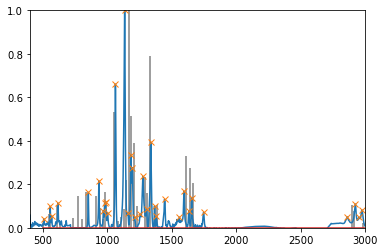

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1653.0 cm-1, height 0.11682850222300857

 19 peaks were assigned. Scaling factor of 0.95 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1165.65,1.00,1.00,-31.65
1,1061.67,1053.55,0.66,0.53,8.12
2,1336.49,1290.10,0.39,0.23,46.39
3,1182.21,1182.75,0.34,0.52,-0.54
4,1192.82,1206.50,0.28,0.39,-13.68
5,1274.78,1307.20,0.24,0.16,-32.42
6,933.42,909.15,0.22,0.14,24.27
7,1594.92,1609.30,0.17,0.33,-14.38
8,851.46,833.15,0.16,0.16,18.31
9,1653.74,1653.00,0.14,0.12,0.74



 Mean absolute error: 

MAE = 22.86 cm-1
22.859889473684223 19
pbe0-d3
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[497.79999999999995, 545.3, 552.9, 606.1, 629.85, 729.5999999999999, 776.15, 803.6999999999999, 836.0, 912.9499999999999, 943.3499999999999, 967.0999999999999, 981.3499999999999, 1053.55, 1080.1499999999999, 1105.8, 1129.55, 1143.8, 1166.6, 1183.7, 1204.6, 1235.0, 1292.0, 1310.05, 1332.85, 1368.95, 1381.3, 1613.1, 1643.5, 1653.9499999999998, 1663.4499999999998, 2901.2999999999997, 2909.85, 2980.1499999999996, 3014.35]


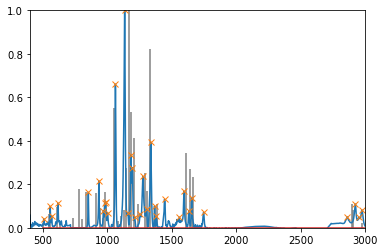

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1653.9499999999998 cm-1, height 0.12139191807249894

 19 peaks were assigned. Scaling factor of 0.95 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1166.60,1.00,1.00,-32.61
1,1061.67,1053.55,0.66,0.55,8.12
2,1336.49,1292.00,0.39,0.25,44.49
3,1182.21,1183.70,0.34,0.53,-1.49
4,1192.82,1204.60,0.28,0.41,-11.78
5,1274.78,1310.05,0.24,0.17,-35.27
6,933.42,912.95,0.22,0.16,20.47
7,1594.92,1643.50,0.17,0.27,-48.58
8,851.46,836.00,0.16,0.17,15.46
9,1653.74,1653.95,0.14,0.12,-0.21



 Mean absolute error: 

MAE = 24.18 cm-1
24.181784210526303 19
b3lyp
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[421.001, 497.721, 540.876, 549.507, 580.1949999999999, 600.334, 610.8829999999999, 658.833, 724.045, 767.1999999999999, 780.626, 800.765, 824.74, 909.132, 940.779, 953.246, 971.467, 1005.0319999999999, 1043.392, 1068.326, 1085.588, 1101.8909999999998, 1126.825, 1141.21, 1163.267, 1179.57, 1223.684, 1271.634, 1306.158, 1328.215, 1338.764, 1384.796, 1398.222, 1590.022, 1629.341, 1646.6029999999998, 2902.893, 2921.114, 2968.105, 3005.506, 3057.292]


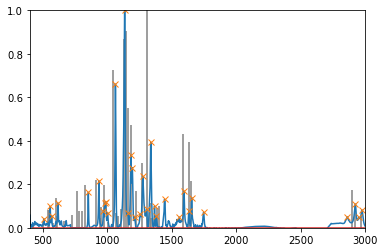

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1653.742 cm-1, height 0.13913442294863243, best theoretical match is 1646.6029999999998 cm-1, height 0.2147819460691271
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1398.222 cm-1, height 0.10142846966807903

 18 peaks were assigned. Scaling factor of 0.959 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1126.83,1.00,0.87,7.17
1,1061.67,1043.39,0.66,0.73,18.28
2,1336.49,1271.63,0.39,0.30,64.86
3,1182.21,1179.57,0.34,0.48,2.64
4,1192.82,1163.27,0.28,0.55,29.55
5,1274.78,1223.68,0.24,0.17,51.10
6,933.42,909.13,0.22,0.22,24.29
7,1594.92,1646.60,0.17,0.21,-51.68
8,851.46,824.74,0.16,0.20,26.72
9,1443.53,1398.22,0.13,0.10,45.31



 Mean absolute error: 

MAE = 24.39 cm-1
24.385827777777763 18
b3lyp-d3
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[423.878, 498.68, 540.876, 551.425, 584.031, 601.293, 612.8009999999999, 662.669, 725.963, 769.1179999999999, 781.5849999999999, 802.683, 831.453, 914.886, 946.533, 956.1229999999999, 973.385, 1005.991, 1045.31, 1071.203, 1089.424, 1099.973, 1127.7839999999999, 1144.087, 1166.144, 1176.693, 1226.561, 1245.741, 1273.552, 1309.0349999999999, 1333.01, 1384.796, 1398.222, 1596.735, 1632.2179999999998, 1643.7259999999999, 1651.398, 2900.016, 2918.237, 2967.1459999999997, 3005.506, 3058.2509999999997]


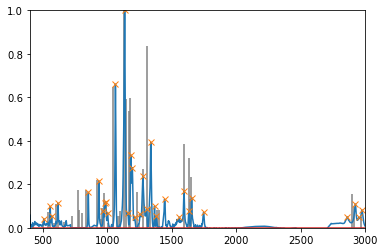

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0

 20 peaks were assigned. Scaling factor of 0.959 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1127.78,1.00,1.00,6.21
1,1061.67,1045.31,0.66,0.65,16.36
2,1336.49,1273.55,0.39,0.27,62.94
3,1182.21,1176.69,0.34,0.60,5.52
4,1192.82,1166.14,0.28,0.54,26.67
5,1274.78,1226.56,0.24,0.16,48.22
6,933.42,914.89,0.22,0.22,18.54
7,1594.92,1632.22,0.17,0.32,-37.30
8,851.46,831.45,0.16,0.17,20.01
9,1653.74,1651.40,0.14,0.23,2.34



 Mean absolute error: 

MAE = 20.99 cm-1
20.994345000000017 20
cam-b3lyp
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[501.17699999999996, 545.874, 556.3349999999999, 607.689, 619.101, 732.27, 776.967, 791.232, 809.3009999999999, 835.929, 917.7149999999999, 950.049, 971.9219999999999, 989.04, 1009.011, 1059.414, 1086.042, 1114.572, 1146.906, 1172.5829999999999, 1188.75, 1211.5739999999998, 1243.908, 1303.821, 1340.9099999999999, 1381.8029999999999, 1394.166, 1635.72, 1661.397, 1670.907, 1685.172, 2907.207, 2918.6189999999997, 2978.5319999999997, 3009.915]


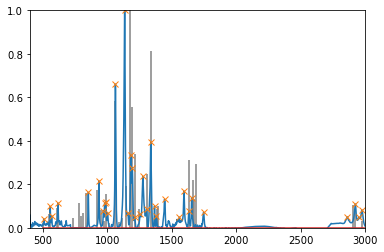

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1274.78 cm-1, height 0.2360809984434067, best theoretical match is 1303.821 cm-1, height 0.24765795356155734

 19 peaks were assigned. Scaling factor of 0.951 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1172.58,1.00,1.00,-38.59
1,1061.67,1059.41,0.66,0.58,2.26
2,1336.49,1303.82,0.39,0.25,32.67
3,1182.21,1188.75,0.34,0.56,-6.54
4,1192.82,1211.57,0.28,0.34,-18.76
5,933.42,917.71,0.22,0.17,15.71
6,1594.92,1635.72,0.17,0.31,-40.80
7,851.46,835.93,0.16,0.16,15.53
8,1653.74,1661.40,0.14,0.22,-7.65
9,1443.53,1394.17,0.13,0.10,49.36



 Mean absolute error: 

MAE = 22.33 cm-1
22.329699999999978 19
cam-b3lyp-d3
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[501.17699999999996, 545.874, 558.237, 608.64, 620.052, 627.66, 733.221, 777.918, 793.134, 810.252, 839.733, 922.4699999999999, 952.9019999999999, 974.775, 989.991, 1009.011, 1061.316, 1086.993, 1117.425, 1138.347, 1149.759, 1173.5339999999999, 1191.6029999999998, 1210.623, 1246.761, 1305.723, 1341.8609999999999, 1381.8029999999999, 1395.117, 1639.524, 1663.299, 1673.76, 1688.9759999999999, 2905.305, 2917.6679999999997, 2978.5319999999997, 3008.964]


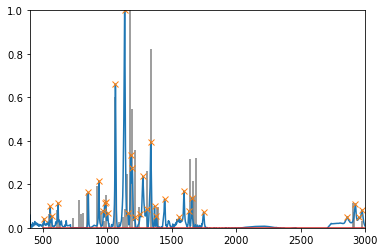

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1274.78 cm-1, height 0.2360809984434067, best theoretical match is 1305.723 cm-1, height 0.25993646263389064

 19 peaks were assigned. Scaling factor of 0.951 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1173.53,1.00,1.00,-39.54
1,1061.67,1061.32,0.66,0.60,0.36
2,1336.49,1305.72,0.39,0.26,30.77
3,1182.21,1191.60,0.34,0.55,-9.39
4,1192.82,1210.62,0.28,0.36,-17.81
5,933.42,922.47,0.22,0.19,10.95
6,1594.92,1639.52,0.17,0.32,-44.60
7,851.46,839.73,0.16,0.16,11.73
8,1653.74,1663.30,0.14,0.21,-9.56
9,1443.53,1395.12,0.13,0.10,48.41



 Mean absolute error: 

MAE = 22.03 cm-1
22.029384210526292 19
m06l
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[421.293, 493.56899999999996, 536.3639999999999, 546.8249999999999, 598.179, 621.0029999999999, 656.1899999999999, 720.858, 756.045, 767.457, 795.036, 822.615, 900.597, 933.882, 970.971, 988.0889999999999, 1042.296, 1080.336, 1098.405, 1115.523, 1138.347, 1150.71, 1164.024, 1226.79, 1274.34, 1296.213, 1305.723, 1318.086, 1360.8809999999999, 1375.146, 1596.7289999999998, 1635.72, 1652.838, 2897.6969999999997, 2988.042, 3018.4739999999997, 3026.082, 3034.641]


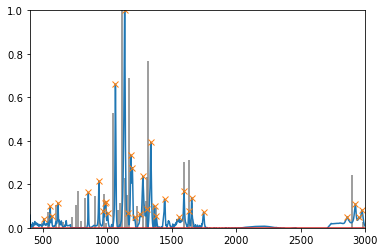

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1652.838 cm-1, height 0.11373285957631424

 19 peaks were assigned. Scaling factor of 0.951 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1115.52,1.00,1.00,18.47
1,1061.67,1042.30,0.66,0.53,19.38
2,1336.49,1318.09,0.39,0.77,18.41
3,1182.21,1138.35,0.34,0.23,43.86
4,1192.82,1150.71,0.28,0.15,42.11
5,1274.78,1274.34,0.24,0.23,0.44
6,933.42,900.60,0.22,0.15,32.83
7,1594.92,1596.73,0.17,0.30,-1.81
8,851.46,822.62,0.16,0.14,28.85
9,1653.74,1652.84,0.14,0.11,0.90



 Mean absolute error: 

MAE = 27.19 cm-1
27.189889473684197 19
wb97-xd
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[498.75, 546.25, 554.8, 606.1, 617.5, 626.05, 730.55, 773.3, 782.8, 804.65, 836.0, 916.75, 946.1999999999999, 957.5999999999999, 970.9, 982.3, 1005.0999999999999, 1052.6, 1082.05, 1109.6, 1129.55, 1142.85, 1165.6499999999999, 1184.6499999999999, 1201.75, 1237.85, 1292.0, 1331.8999999999999, 1380.35, 1394.6, 1634.0, 1658.6999999999998, 1668.1999999999998, 1680.55, 2905.1, 2913.65, 2988.7, 3014.35]


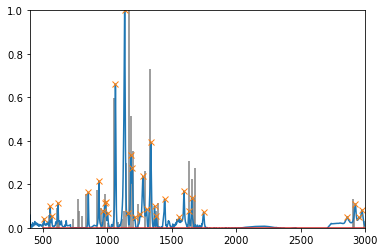

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0

 20 peaks were assigned. Scaling factor of 0.95 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1165.65,1.00,1.00,-31.65
1,1061.67,1052.60,0.66,0.60,9.07
2,1336.49,1331.90,0.39,0.73,4.59
3,1182.21,1184.65,0.34,0.51,-2.44
4,1192.82,1201.75,0.28,0.35,-8.93
5,1274.78,1292.00,0.24,0.26,-17.22
6,933.42,916.75,0.22,0.17,16.67
7,1594.92,1634.00,0.17,0.31,-39.08
8,851.46,836.00,0.16,0.16,15.46
9,1653.74,1658.70,0.14,0.23,-4.96



 Mean absolute error: 

MAE = 20.67 cm-1
20.67204499999996 20
lc-wpbe
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[503.023, 548.5798, 559.0199, 591.2893, 611.2204, 626.4060000000001, 653.9299000000001, 737.4507000000001, 783.0075, 801.0404000000001, 817.1751, 847.5463000000001, 921.5761, 956.6928, 981.3694, 1002.2496000000001, 1047.8064000000002, 1069.6357, 1099.0578, 1146.5128, 1163.5966, 1194.9169000000002, 1204.4079000000002, 1228.1354000000001, 1264.2012, 1286.9796000000001, 1321.1472, 1330.6382, 1339.1801, 1351.5184000000002, 1365.7549000000001, 1379.0423, 1388.5333, 1678.0088, 1693.1944, 1705.5327000000002, 1722.6165, 2939.3627, 3031.4254, 3045.6619, 3056.1020000000003]


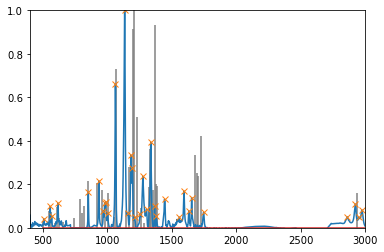

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1264.2012 cm-1, height 0.08946370655020777

 19 peaks were assigned. Scaling factor of 0.9491 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1194.92,1.00,0.92,-60.92
1,1061.67,1069.64,0.66,0.73,-7.96
2,1336.49,1339.18,0.39,0.20,-2.69
3,1182.21,1163.60,0.34,0.28,18.61
4,1192.82,1228.14,0.28,0.51,-35.32
5,1274.78,1321.15,0.24,0.19,-46.37
6,933.42,921.58,0.22,0.20,11.85
7,1594.92,1678.01,0.17,0.33,-83.09
8,851.46,847.55,0.16,0.22,3.91
9,1653.74,1693.19,0.14,0.25,-39.45



 Mean absolute error: 

MAE = 28.81 cm-1
28.80765789473689 19
lc-wpbe-d3
Theoretical peaks detected of min. height of 0.04, vertical threshold 0.0 and 8-point distance between neighbors are: 
[430.89140000000003, 503.9721, 549.5289, 559.969, 595.0857000000001, 611.2204, 627.3551, 654.879, 739.3489000000001, 785.8548000000001, 801.9895, 818.1242000000001, 852.2918000000001, 927.2707, 959.5401, 985.1658000000001, 1004.1478000000001, 1050.6537, 1070.5848, 1100.0069, 1148.411, 1166.4439, 1195.866, 1205.357, 1227.1863, 1267.0485, 1290.776, 1323.9945, 1332.5364000000002, 1340.1292, 1352.4675, 1366.7040000000002, 1379.0423, 1389.4824, 1681.8052, 1695.0926000000002, 1707.4309, 1726.4129, 2937.4645, 3030.4763000000003, 3045.6619, 3055.1529]


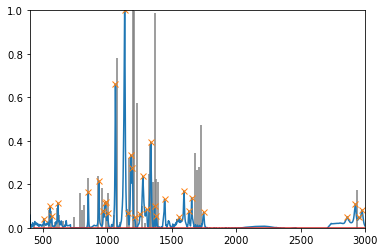

Error calculation:
Maximum exp. peak at  1133.995  height:  1.0
Consider these matches manually:
For experimental peak 1192.816 cm-1, height 0.27688597954191685, best theoretical match is 1166.4439 cm-1, height 0.321582911598934
Consider these matches manually:
For experimental peak 1594.921 cm-1, height 0.16902240382477207, best theoretical match is 1695.0926000000002 cm-1, height 0.2663270435214486
Consider these matches manually:
For experimental peak 1303.708 cm-1, height 0.0847648432288192, best theoretical match is 1267.0485 cm-1, height 0.10157810856857828
Consider these matches manually:
For experimental peak 1631.563 cm-1, height 0.07874694240604847, best theoretical match is 1267.0485 cm-1, height 0.10157810856857828

 16 peaks were assigned. Scaling factor of 0.9491 was used for the theoretical spectrum.



,Exp. waveno.,Scaled theo. waveno.,Exp. peak height,Theo. peak height,Deviations
0,1133.99,1195.87,1.00,1.00,-61.87
1,1061.67,1070.58,0.66,0.78,-8.91
2,1336.49,1340.13,0.39,0.23,-3.64
3,1182.21,1166.44,0.34,0.32,15.76
4,1274.78,1323.99,0.24,0.25,-49.21
5,933.42,927.27,0.22,0.24,6.15
6,851.46,852.29,0.16,0.23,-0.83
7,1653.74,1695.09,0.14,0.27,-41.35
8,1443.53,1389.48,0.13,0.21,54.05
9,986.46,1004.15,0.12,0.16,-17.69



 Mean absolute error: 

MAE = 29.21 cm-1
29.206637500000035 16
Calculated MAEs for each functional:


,MAE,No. of assigned peaks
pbe0,22.86,19
pbe0-d3,24.18,19
b3lyp,24.39,18
b3lyp-d3,20.99,20
cam-b3lyp,22.33,19
cam-b3lyp-d3,22.03,19
m06l,27.19,19
wb97-xd,20.67,20
lc-wpbe,28.81,19
lc-wpbe-d3,29.21,16


In [174]:
#For selected functionals read the spectra and calculate the MAEs
MAEs={}
peaks_assigned={}
for funs in functional:
    print(funs)
    theo_spec=read_theo(molecule,form,funs) 
    SF=scaling_f[funs]
    
    wavenumbers_theo=SF*theo_spec[:,0]
    heights_theo=theo_spec[:,1]/max(theo_spec[:,1])
    
    peaks_theo=theo_peaks(SF,wavenumbers_theo,heights_theo)
    
    y_theo=[wavenumbers_theo[j] for j in peaks_theo]
    print("Theoretical peaks detected of min. height of {}, vertical threshold {} and {}-point distance between neighbors are: ".format(H,T,D))
    print(y_theo)
    h_theo=[heights_theo[j] for j in peaks_theo]
    #print(h_theo)
    no_of_peaks=len(y_theo)
    
    #draw the spectra comparison
    plt.plot(wavenumbers,heights)
    plt.ylim(ymin=0,ymax=1)
    plt.xlim(xmin=400,xmax=4000)
    plt.plot(y,heights[peaks],"x")
#fig, ax = plt.subplots()
    plt.stem(y_theo, heights_theo[peaks_theo],markerfmt=' ',linefmt='grey')
#plt.stem(y_theo,heights[peaks_theo] ,markerfmt=' ',linefmt='grey')
    plt.ylim(ymin=0,ymax=1)
    plt.xlim(xmin=400,xmax=3000)
    plt.show()
    m,n=calculate_MAE()
    MAEs[funs]=m
    peaks_assigned[funs]=n
    print(m,n)
    
pd.set_option('display.precision', 2)
print("Calculated MAEs for each functional:")
df=pd.DataFrame.from_dict(MAEs,orient='index',columns=['MAE'])
df['No. of assigned peaks']=peaks_assigned.values()

display(df)
#for funs in functional:
#    print(funs,MAEs[funs],peaks_assigned[funs])
    